# Bibliotecas

In [1]:
import os
import glob
import shutil
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Arquivos do projeto


In [2]:
# Área de trabalho do projeto
drive.mount('/content/drive')
workspace_path = '/content/drive/MyDrive/Workspace'

Mounted at /content/drive


In [3]:
# Caminho para os arquivos dos dados
data_path = f'{workspace_path}/fiap/pos-tech/data-analytics/fase-4/dados'

In [4]:
# Pasta temporária
temp_path = 'tmp'
os.makedirs(temp_path, exist_ok=True)

In [5]:
# Copiando os arquivos do backup do banco de dados
for part_file in glob.glob(f'{data_path}/anp_dump.tar.gz.part-*'):
    shutil.copy(part_file, temp_path)

In [6]:
# Remontando o arquivo de backup no formato .tar.gz
!cat tmp/anp_dump.tar.gz.part-* > tmp/anp_dump.tar.gz

In [7]:
# Descompactando o arquivo de backup do banco de dados
!tar -xzvf tmp/anp_dump.tar.gz

tmp/anp_dump.backup


# PostgreSQL

In [8]:
# Instalação
!apt-get install -y postgresql

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcommon-sense-perl libjson-perl libjson-xs-perl libtypes-serialiser-perl logrotate netbase
  postgresql-14 postgresql-client-14 postgresql-client-common postgresql-common ssl-cert sysstat
Suggested packages:
  bsd-mailx | mailx postgresql-doc postgresql-doc-14 isag
The following NEW packages will be installed:
  libcommon-sense-perl libjson-perl libjson-xs-perl libtypes-serialiser-perl logrotate netbase
  postgresql postgresql-14 postgresql-client-14 postgresql-client-common postgresql-common ssl-cert
  sysstat
0 upgraded, 13 newly installed, 0 to remove and 49 not upgraded.
Need to get 18.4 MB of archives.
After this operation, 51.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 logrotate amd64 3.19.0-1ubuntu1.1 [54.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd6

In [9]:
# Iniciando o serviço
!service postgresql start

 * Starting PostgreSQL 14 database server
   ...done.


In [10]:
# Configurando o usuário postgres
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres';"

ALTER ROLE


In [11]:
# Criando o banco de dados
!sudo -u postgres psql -c "CREATE DATABASE anp;"

CREATE DATABASE


In [12]:
# Restaurando os dados para o PostgreSQL
!PGPASSWORD=postgres pg_restore -U postgres -d anp -h localhost -v tmp/anp_dump.backup

pg_restore: connecting to database for restore
pg_restore: creating TABLE "public.preco_combustivel"
pg_restore: processing data for table "public.preco_combustivel"


# Explorando os dados

In [13]:
# Conexão com o PostgreSQL
conn = psycopg2.connect(
    host='localhost',
    port='5432',
    database='anp',
    user='postgres',
    password='postgres'
)

In [14]:
# Carregando os dados do PostgreSQL em um dataframe Pandas
df = pd.io.sql.read_sql_query("""
  SELECT  regiao_sigla      AS regiao
          , estado_sigla    AS estado
          , municipio
          , bandeira
          , produto
          , valor_de_venda  AS valor_venda
          , data_da_coleta  AS data_coleta
  FROM    public.preco_combustivel
""", conn)

<ipython-input-14-a8c3dfb0f4f5>:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.io.sql.read_sql_query("""


In [15]:
# Ajustando a coluna data_da_coleta
df['data_coleta'] = pd.to_datetime(df['data_coleta'], format='%Y-%m-%d')

# Separando ano e mês
df['ano'] = df['data_coleta'].dt.year
df['mes'] = df['data_coleta'].dt.month

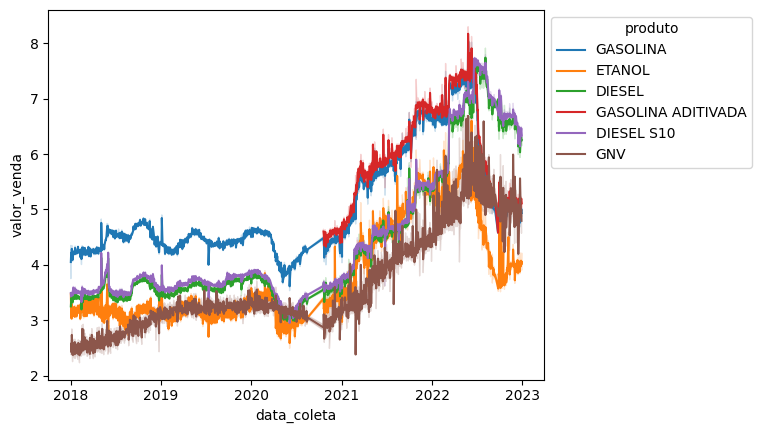

In [16]:
ax = sns.lineplot(data=df, x='data_coleta', y='valor_venda', hue='produto')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [17]:
# Separando os produtos em dataframes
df_diesel_s10 = df[df['produto'] == 'DIESEL S10']
df_diesel = df[df['produto'] == 'DIESEL']
df_etanol = df[df['produto'] == 'ETANOL']
df_gnv = df[df['produto'] == 'GNV']
df_gasolina_c = df[df['produto'] == 'GASOLINA COMUM']
df_gasolina_a = df[df['produto'] == 'GASOLINA ADITIVADA']

# Funções para geração de gráficos

In [18]:
def create_boxplot(title, labelx, labely, x, y, dataset):
  sns.set_palette('Accent')
  sns.set_style('darkgrid')
  ax = sns.boxplot(x=x, y=y, data=dataset)
  ax.figure.set_size_inches(12, 6)
  ax.set_title(title, loc='left', fontsize=18)
  ax.set_xlabel(labelx, fontsize=14)
  ax.set_ylabel(labely, fontsize=14)

In [19]:
def create_boxplot_simple(y, dataset):
  ax = sns.boxplot(y=y, data=dataset)
  ax.figure.set_size_inches(4, 4)

# Gráficos

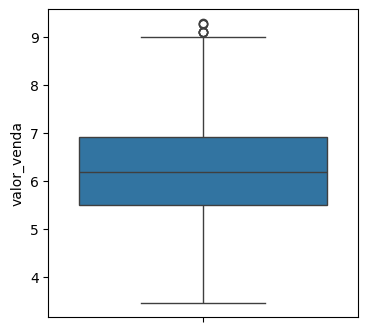

In [20]:
create_boxplot_simple('valor_venda', df_gasolina_a)

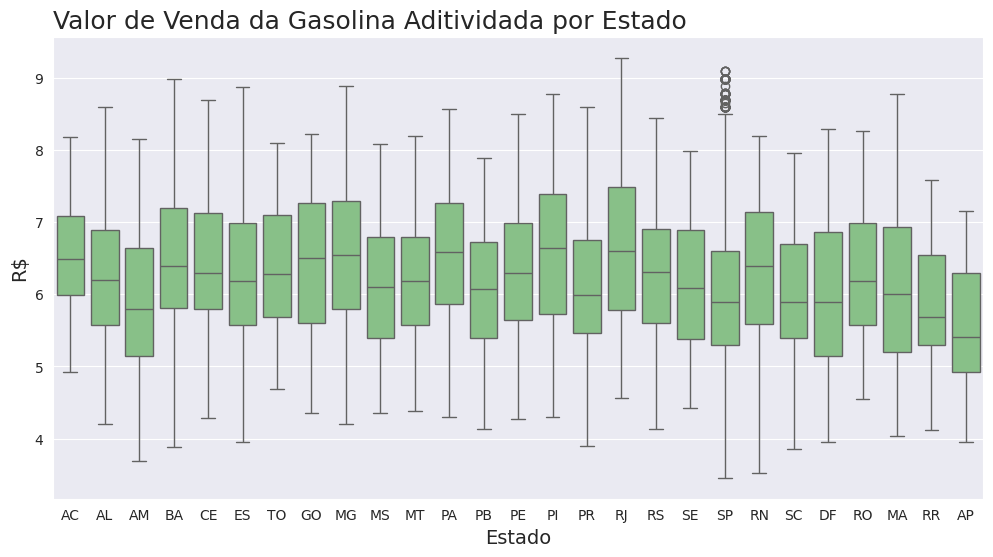

In [21]:
create_boxplot('Valor de Venda da Gasolina Aditividada por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_gasolina_a)